In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import json
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)', engine='python')


df['friends'] = [json.loads(x) for x in df['friends']]
df['id'] = [int(str(x).replace('"', '')) for x in df['id']]
df['screenName'] = [x.replace('"', '') for x in df['screenName']]

data = df[df['friendsCount'] < 300]

In [ ]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
numeric_columns.head()

,id,followersCount,friendsCount,lastSeen
0,1969527638,319,112,1472271687519
1,51878493,275,115,1472270622663
2,1393409100,120,107,1472804144409
4,710130422907207680,128,218,1472271397356
5,3649469655,479,131,1472736978337


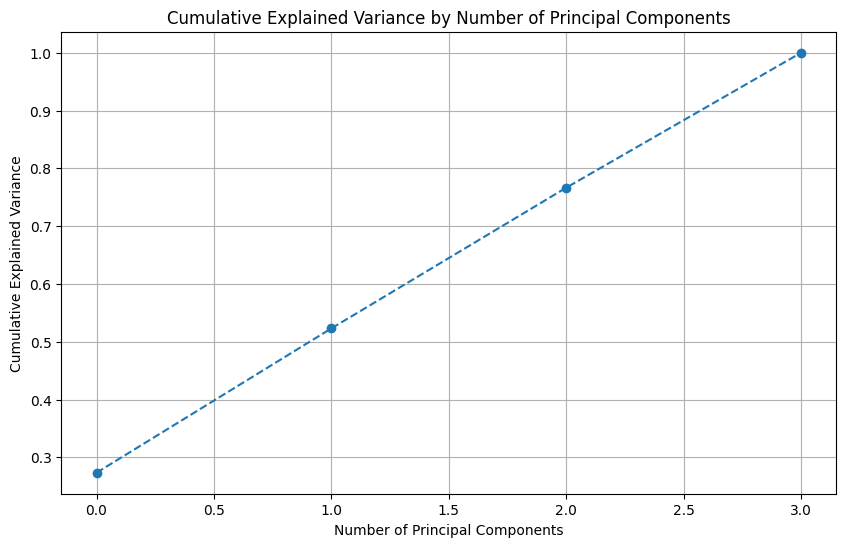

,Principal Component,Explained Variance Ratio
0,PC1,0.273411
1,PC2,0.249647
2,PC3,0.243418
3,PC4,0.233524


In [ ]:
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_columns)

pca = PCA()
pca_result = pca.fit_transform(numeric_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

# Plot pour Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Display individual explained variance
variance_info = {
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio
}

variance_df = pd.DataFrame(variance_info)
variance_df


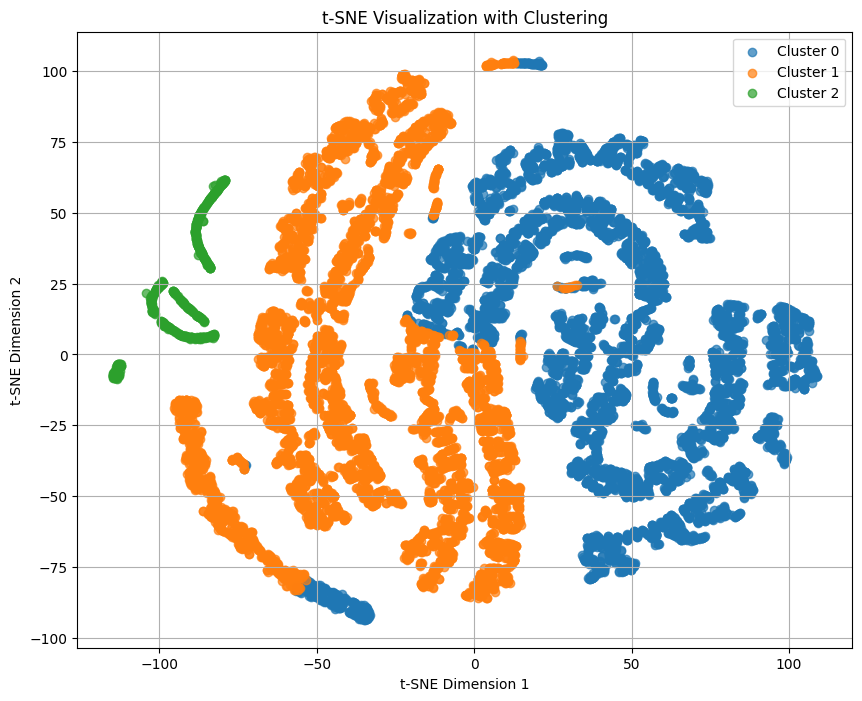

0.47122267586370076

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(numeric_data_scaled)

# clustering avec K-Means for visualization
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(numeric_data_scaled)

tsne_df = pd.DataFrame({
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1],
    'Cluster': clusters
})

plt.figure(figsize=(10, 8))
for cluster in sorted(tsne_df['Cluster'].unique()):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('t-SNE Visualization with Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(numeric_data_scaled, clusters)

silhouette_avg


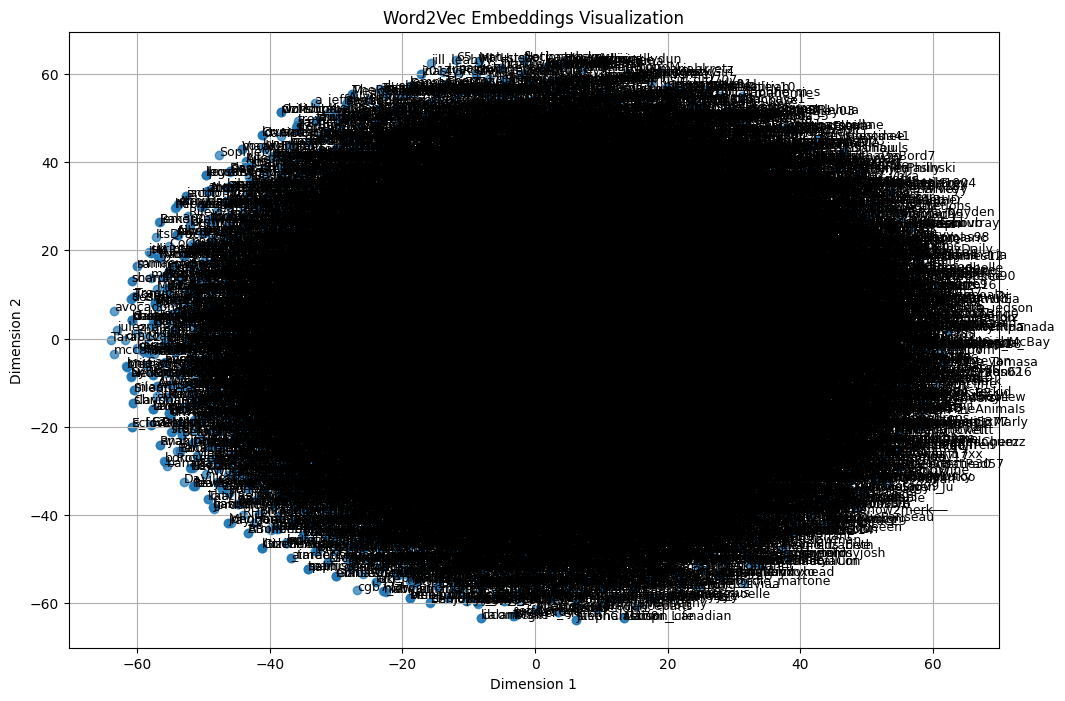

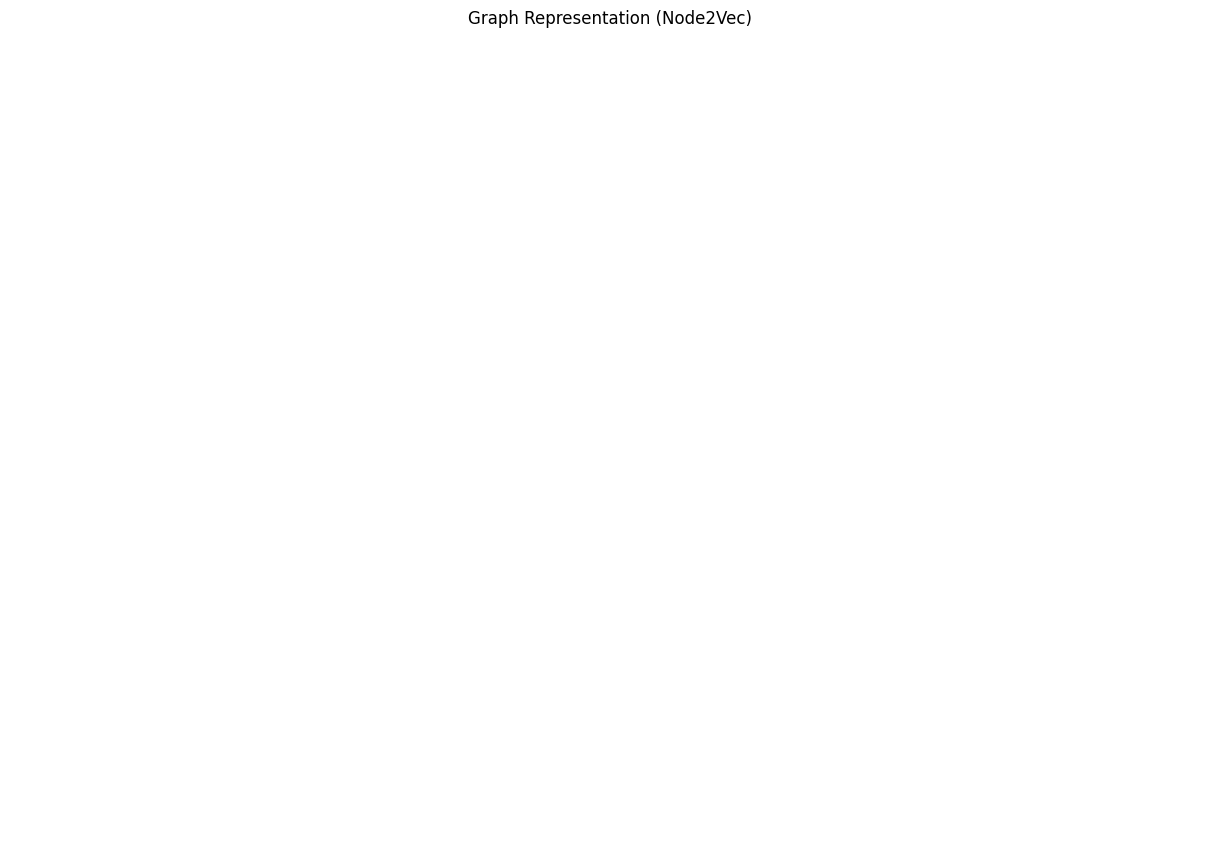

In [ ]:
def apply_word2vec(text_data):
    tokenized_text = text_data.str.split().tolist()
    word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=50, window=5, min_count=1, workers=4, sg=0)
    return word2vec_model

def apply_node2vec(similarity_matrix, threshold=0.7):
    graph = nx.Graph()
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=similarity_matrix[i, j])
    return graph

def visualize_word2vec(word2vec_model):
    words = list(word2vec_model.wv.index_to_key)
    word_vectors = word2vec_model.wv[words]
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(word_vectors)
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
    for i, word in enumerate(words):
        plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)
    plt.title('Word2Vec Embeddings Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

def visualize_node2vec(graph):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=False, node_size=30, alpha=0.7)
    plt.title('Graph Representation (Node2Vec)')
    plt.show()

# chercher s il y a des textual columns pour appliquer les methods
textual_columns = data.select_dtypes(include=['object']).columns
if len(textual_columns) > 0:
    # Utiliser the first textual column pour la demonstration
    text_column = data[textual_columns[0]].astype(str)

    word2vec_model = apply_word2vec(text_column)
    visualize_word2vec(word2vec_model)

    vectorizer = CountVectorizer(max_features=100, stop_words='english')
    word_embeddings = vectorizer.fit_transform(text_column).toarray()
    similarity_matrix = cosine_similarity(word_embeddings)

    graph = apply_node2vec(similarity_matrix)
    visualize_node2vec(graph)
else:
    print("No textual data found in the dataset for embeddings.")


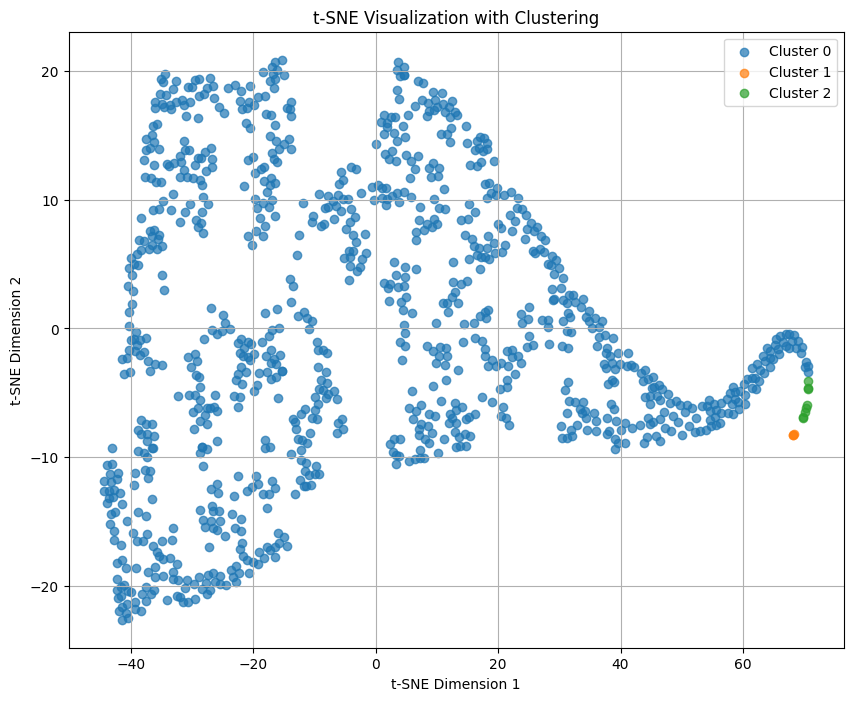

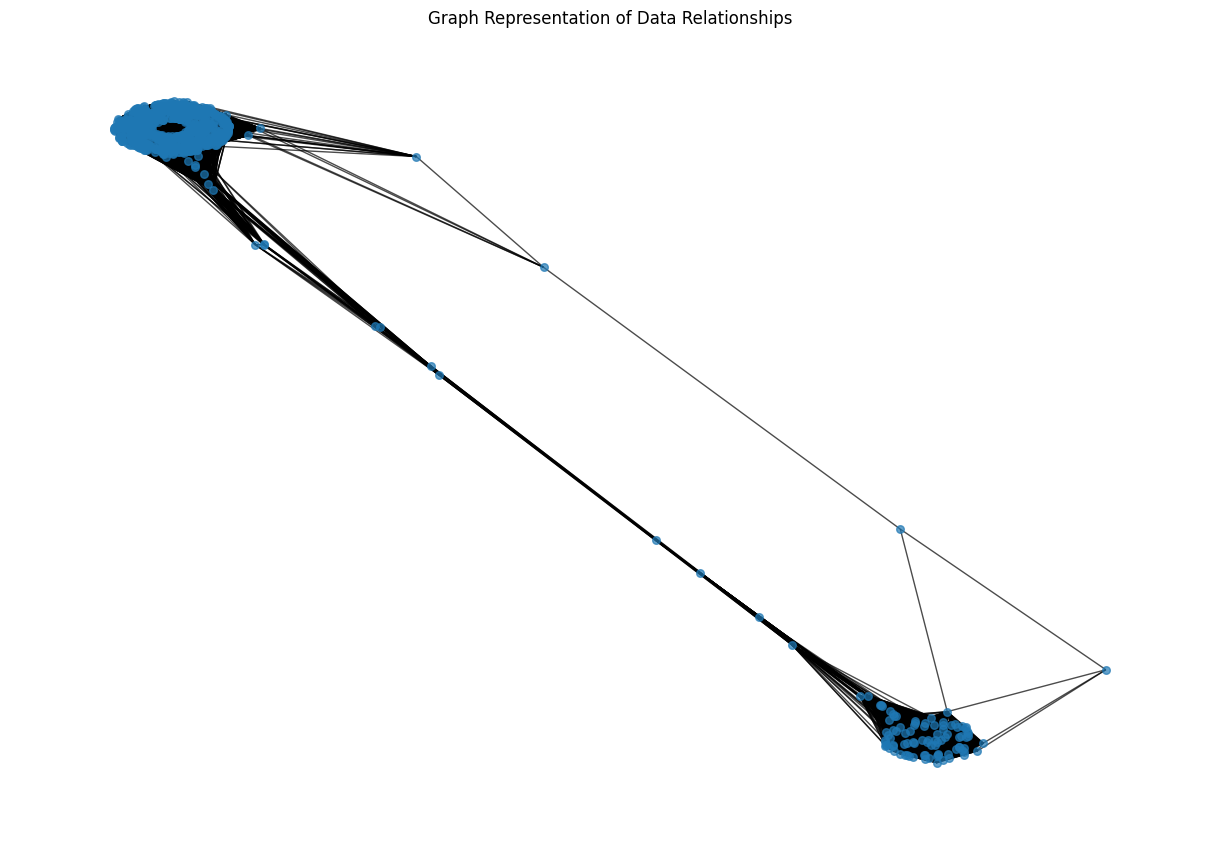

Explained Variance Ratio: [9.99773956e-01 2.26044054e-04]
Silhouette Score: 0.9693922174510256


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import networkx as nx
import matplotlib.pyplot as plt



# Filtrer les colonnes numériques
numeric_columns = data[['followersCount', 'friendsCount']].dropna()

# Vérification si des données numériques sont disponibles
if not numeric_columns.empty:
    # Échantillonnage pour limiter la taille des données
    sampled_data = numeric_columns.sample(n=1000, random_state=42).values

    # Analyse PCA
    def apply_pca(data, n_components=2):
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(data)
        explained_variance = pca.explained_variance_ratio_
        return reduced_data, explained_variance

    # Clustering KMeans
    def apply_clustering(data, n_clusters=3):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        return clusters, silhouette_avg

    # Création d'un graphe à partir de la matrice de similarité
    def create_graph_from_similarity(data, threshold=0.7):
        similarity_matrix = cosine_similarity(data)
        graph = nx.Graph()
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    graph.add_edge(i, j, weight=similarity_matrix[i, j])
        return graph

    # Visualisation avec t-SNE
    def apply_tsne(data, clusters):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(data)
        tsne_df = pd.DataFrame({
            'TSNE1': tsne_result[:, 0],
            'TSNE2': tsne_result[:, 1],
            'Cluster': clusters
        })
        return tsne_df

    # Application des méthodes
    pca_result, explained_variance = apply_pca(sampled_data)
    clusters, silhouette_avg = apply_clustering(pca_result)
    tsne_df = apply_tsne(sampled_data, clusters)

    # Visualisation t-SNE
    plt.figure(figsize=(10, 8))
    for cluster in sorted(tsne_df['Cluster'].unique()):
        cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
        plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {cluster}', alpha=0.7)
    plt.title('t-SNE Visualization with Clustering')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Création et visualisation du graphe
    graph = create_graph_from_similarity(pca_result)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=False, node_size=30, alpha=0.7)
    plt.title('Graph Representation of Data Relationships')
    plt.show()

    # Affichage des résultats
    print("Explained Variance Ratio:", explained_variance)
    print("Silhouette Score:", silhouette_avg)

else:
    print("Aucune donnée numérique trouvée pour l'analyse.")
